# The transient Universe

In [1]:
import numpy as np                        
import scipy.stats                        
import pylab as plt  
import scipy.stats as stats

from scipy.optimize import minimize

import emcee
import corner

plt.style.use('seaborn-v0_8-deep')
plt.rc('text', usetex=True)  
%matplotlib inline
%config InlineBackend.figure_format='retina'

Read the npy file

In [2]:
input_file_path = '/Users/giulia/coding/astrostat/astrostatistics_bicocca_2024/solutions/transient.npy'
data = np.load(input_file_path)

#print(data)

This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon:
- the first column is time (arbitrary units)
- the second column is the flux (arbitrary units)
- the third column are homoescedastic measurement uncertainties on the flux

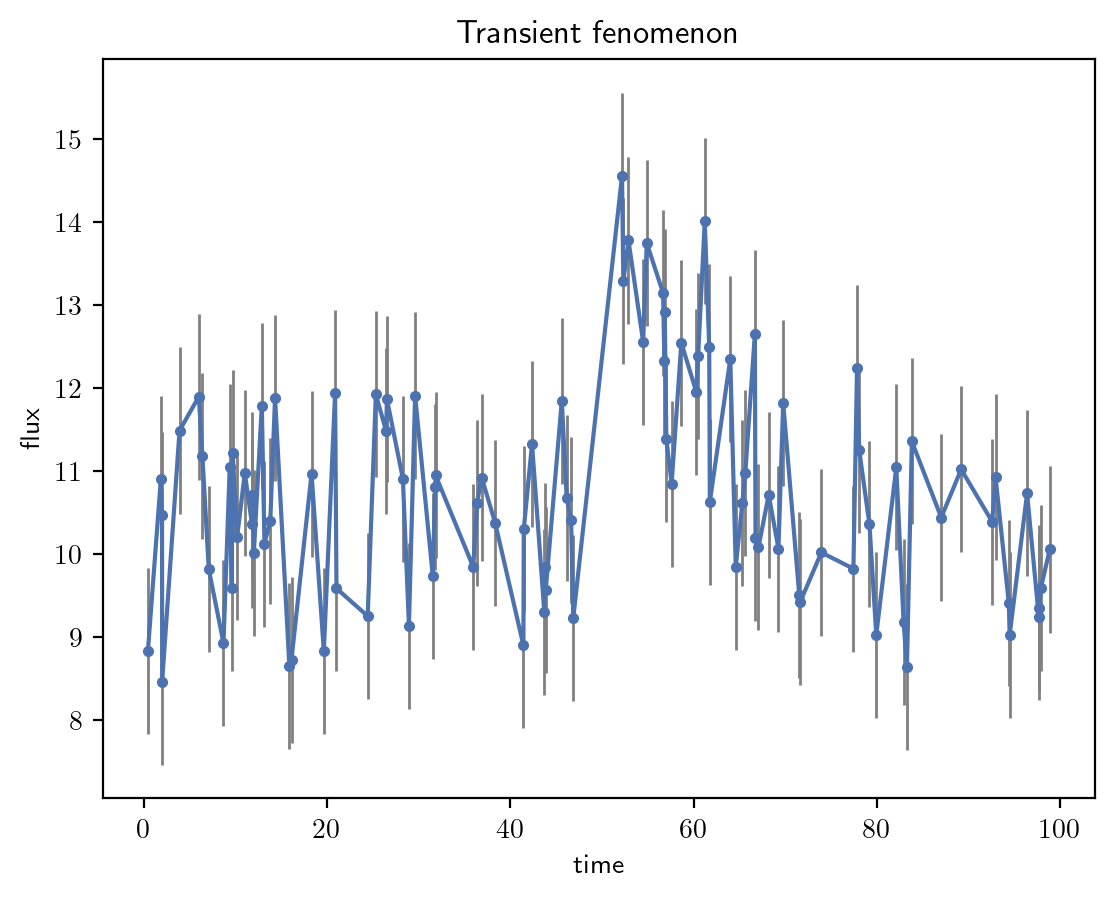

In [3]:
t,y,yerr=data.T

plt.errorbar(t,y,yerr=yerr, marker = '.', ecolor='gray', elinewidth=1)
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Transient fenomenon')

plt.show()

## I use **emcee** to perform a bayesian analysis

Using the tutorial: https://emcee.readthedocs.io/en/stable/tutorials/line/

### Setup

The model

- b = background amplitude
- A = burst amplitude
- t0 = burst epoch
- $\beta$ = how rapidly the burst dies off

In [4]:
def burst_model(x, theta):
    A, b, t0, alpha = theta
    result = b + A * np.exp(-alpha * (x - t0))
    result[x < t0] = b
    return result

The log likelihood

In [5]:
def LogLikelihood(theta, data, model):
    x, y, sigma_y = data.T
    y_model = model(x, theta)
    return -0.5 * np.sum((y-y_model)**2 / sigma_y**2 ) 

The log prior

In [6]:
def Logprior(theta):
    prior_A = stats.uniform(0,50).pdf(theta[0])
    prior_b = stats.uniform(0,50).pdf(theta[1])
    prior_t0 = stats.uniform(0,100).pdf(theta[2])
    prior_alpha = stats.uniform(-5,5).pdf(np.log(theta[3]))

    logPrior = np.log(prior_A * prior_b * prior_t0* prior_alpha)
    if np.isfinite(logPrior):
        return logPrior
    else:
        return -np.inf

The log posterior

In [7]:
def LogPosterior(theta, data, model):
    return LogLikelihood(theta, data, model) + Logprior(theta)

# The posterior in emcee is always something proportional to the actual posterior, since we are neglecting the evidence 

### Estimate the initial parameters using MLE

In [8]:
tgrid=np.linspace(0,100,100)
A_0=5
b_0=10
t0_0=48
alpha_0=1/20

theta_0 = np.array([A_0,b_0,t0_0,alpha_0])

In [9]:
_logL = lambda par : -LogLikelihood(par, data, burst_model)
best_params = scipy.optimize.fmin_bfgs(_logL, theta_0, disp=False)

A, b, t0, alpha = best_params
print(best_params)

[ 4.40544511 10.28787803 50.94413365  0.11890548]


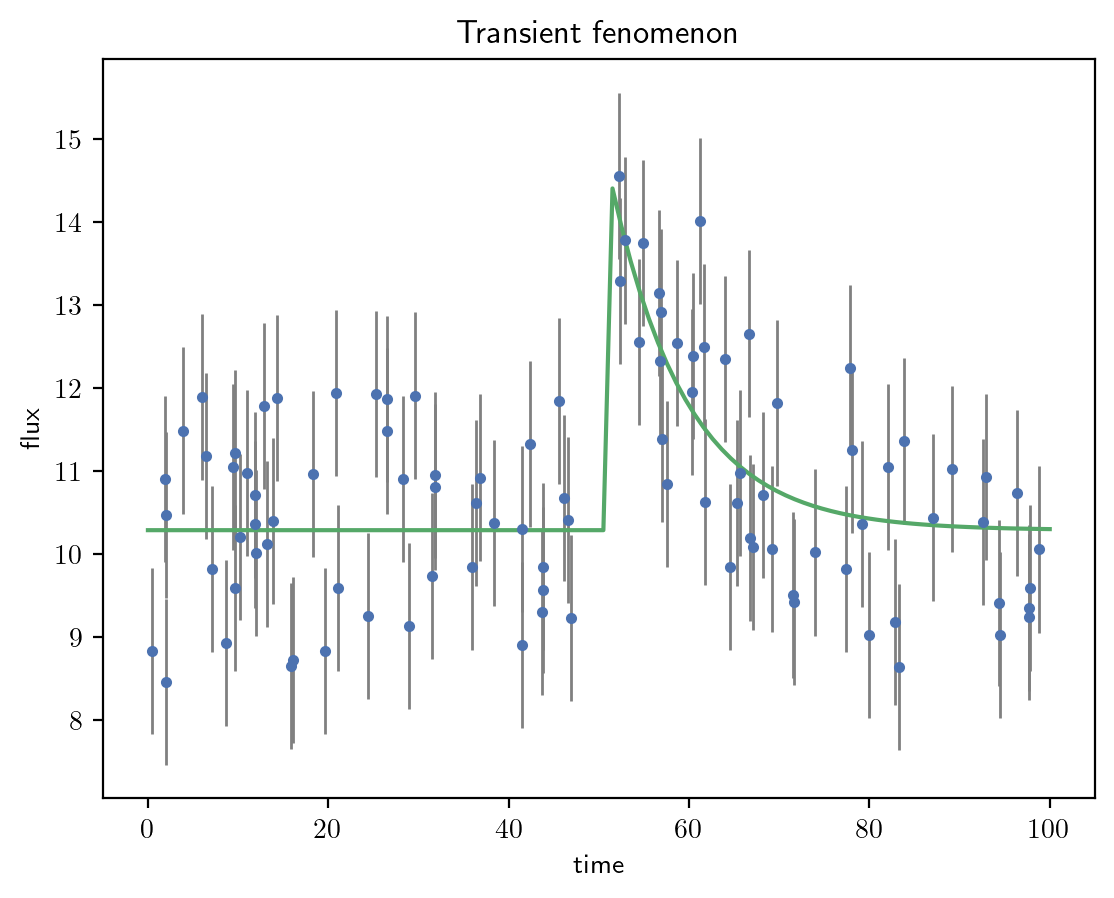

In [10]:
tgrid=np.linspace(0,100,100)

ygrid = burst_model(tgrid,best_params)

plt.errorbar(t,y,yerr=yerr, fmt='.', ecolor='gray', elinewidth=1)
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Transient fenomenon')
plt.plot(tgrid,ygrid);

### MCMC (emcee)

In [11]:
ndim = 4             # n of parameters
nwalkers = 20        # n of MCMC walkers
nsteps = 10000       # n of MCMC steps for each walker

np.random.seed(0)
starting_guesses = theta_0 + 0.05 * np.random.randn(nwalkers, ndim)

# sample the posterior
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=[data, burst_model])
_ = sampler.run_mcmc(starting_guesses, nsteps, progress=True)

/var/folders/lx/nx_0fbmn2xxcrxcn7tmrlntm0000gn/T/ipykernel_25629/1764417970.py:5: RuntimeWarning: invalid value encountered in log
  prior_alpha = stats.uniform(-5,5).pdf(np.log(theta[3]))
  0%|                                                 | 0/10000 [00:00<?, ?it/s]/var/folders/lx/nx_0fbmn2xxcrxcn7tmrlntm0000gn/T/ipykernel_25629/1764417970.py:7: RuntimeWarning: divide by zero encountered in log
  logPrior = np.log(prior_A * prior_b * prior_t0* prior_alpha)
100%|█████████████████████████████████████| 10000/10000 [05:29<00:00, 30.32it/s]


Visualize the chains

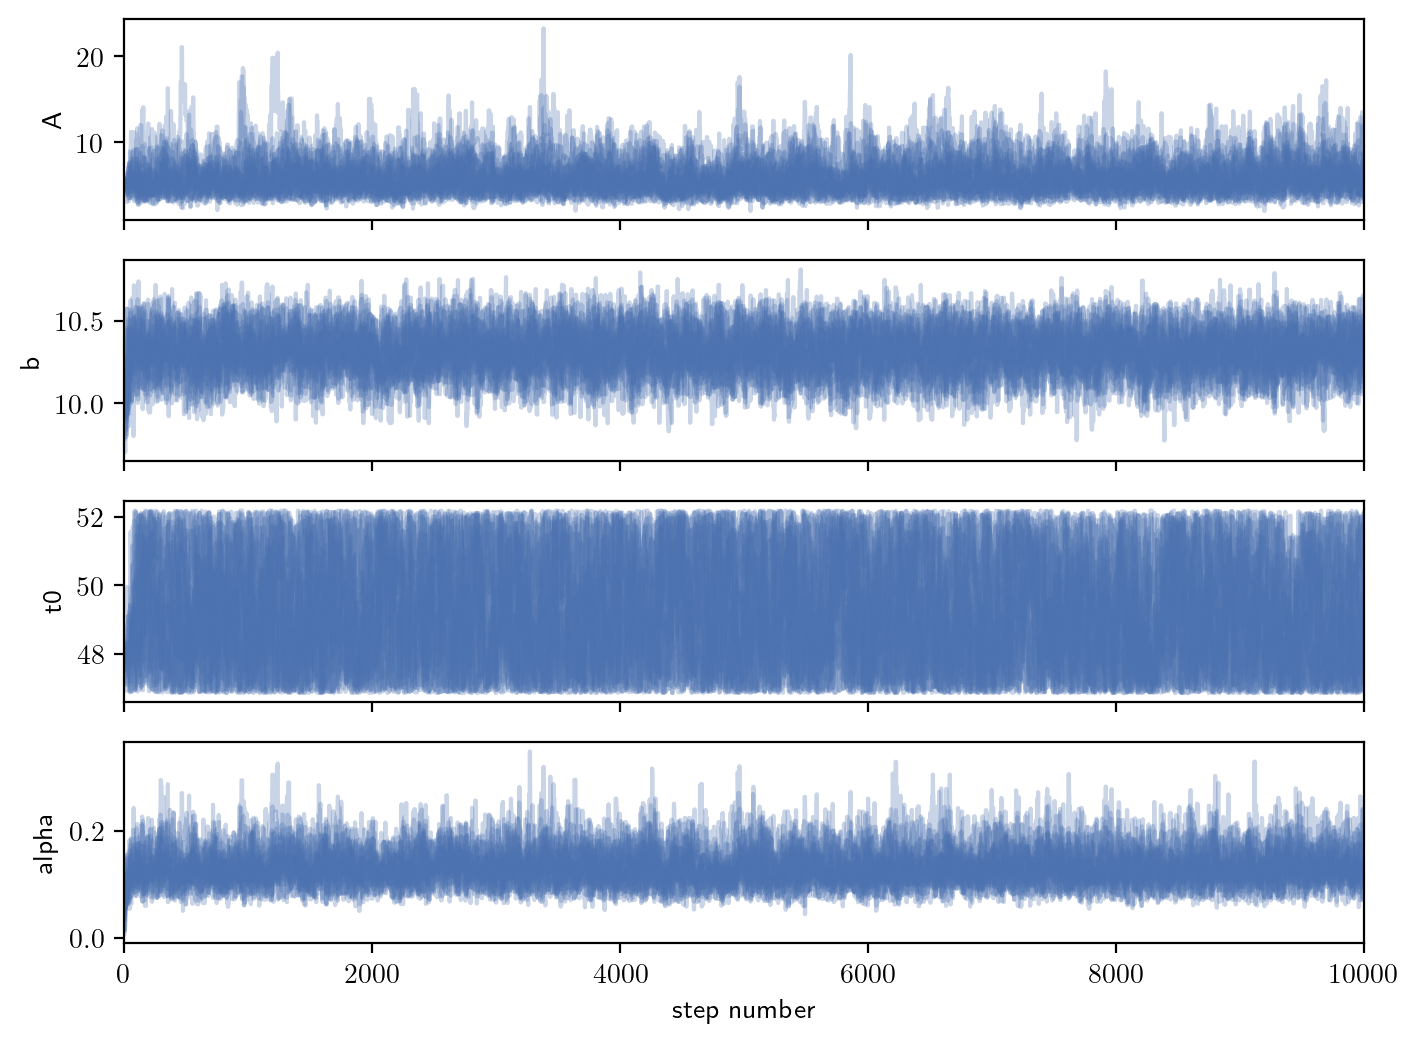

In [12]:
fig, axes = plt.subplots(4, figsize=(8, 6), sharex=True)
samples = sampler.get_chain()
labels = ["A","b","t0","alpha"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "C0", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.set_xlim(0, len(samples))

axes[-1].set_xlabel("step number");

Burn-in and thin the chain, using autocorrelation length

In [13]:
tau = sampler.get_autocorr_time()
print(tau)

[81.22555949 56.17463184 80.99359987 66.02118502]


In [14]:
thin_samples = sampler.get_chain(discard=4*int(max(tau)), thin=int(max(tau)), flat=True)
print(thin_samples.shape)

(2380, 4)


### Corner plots

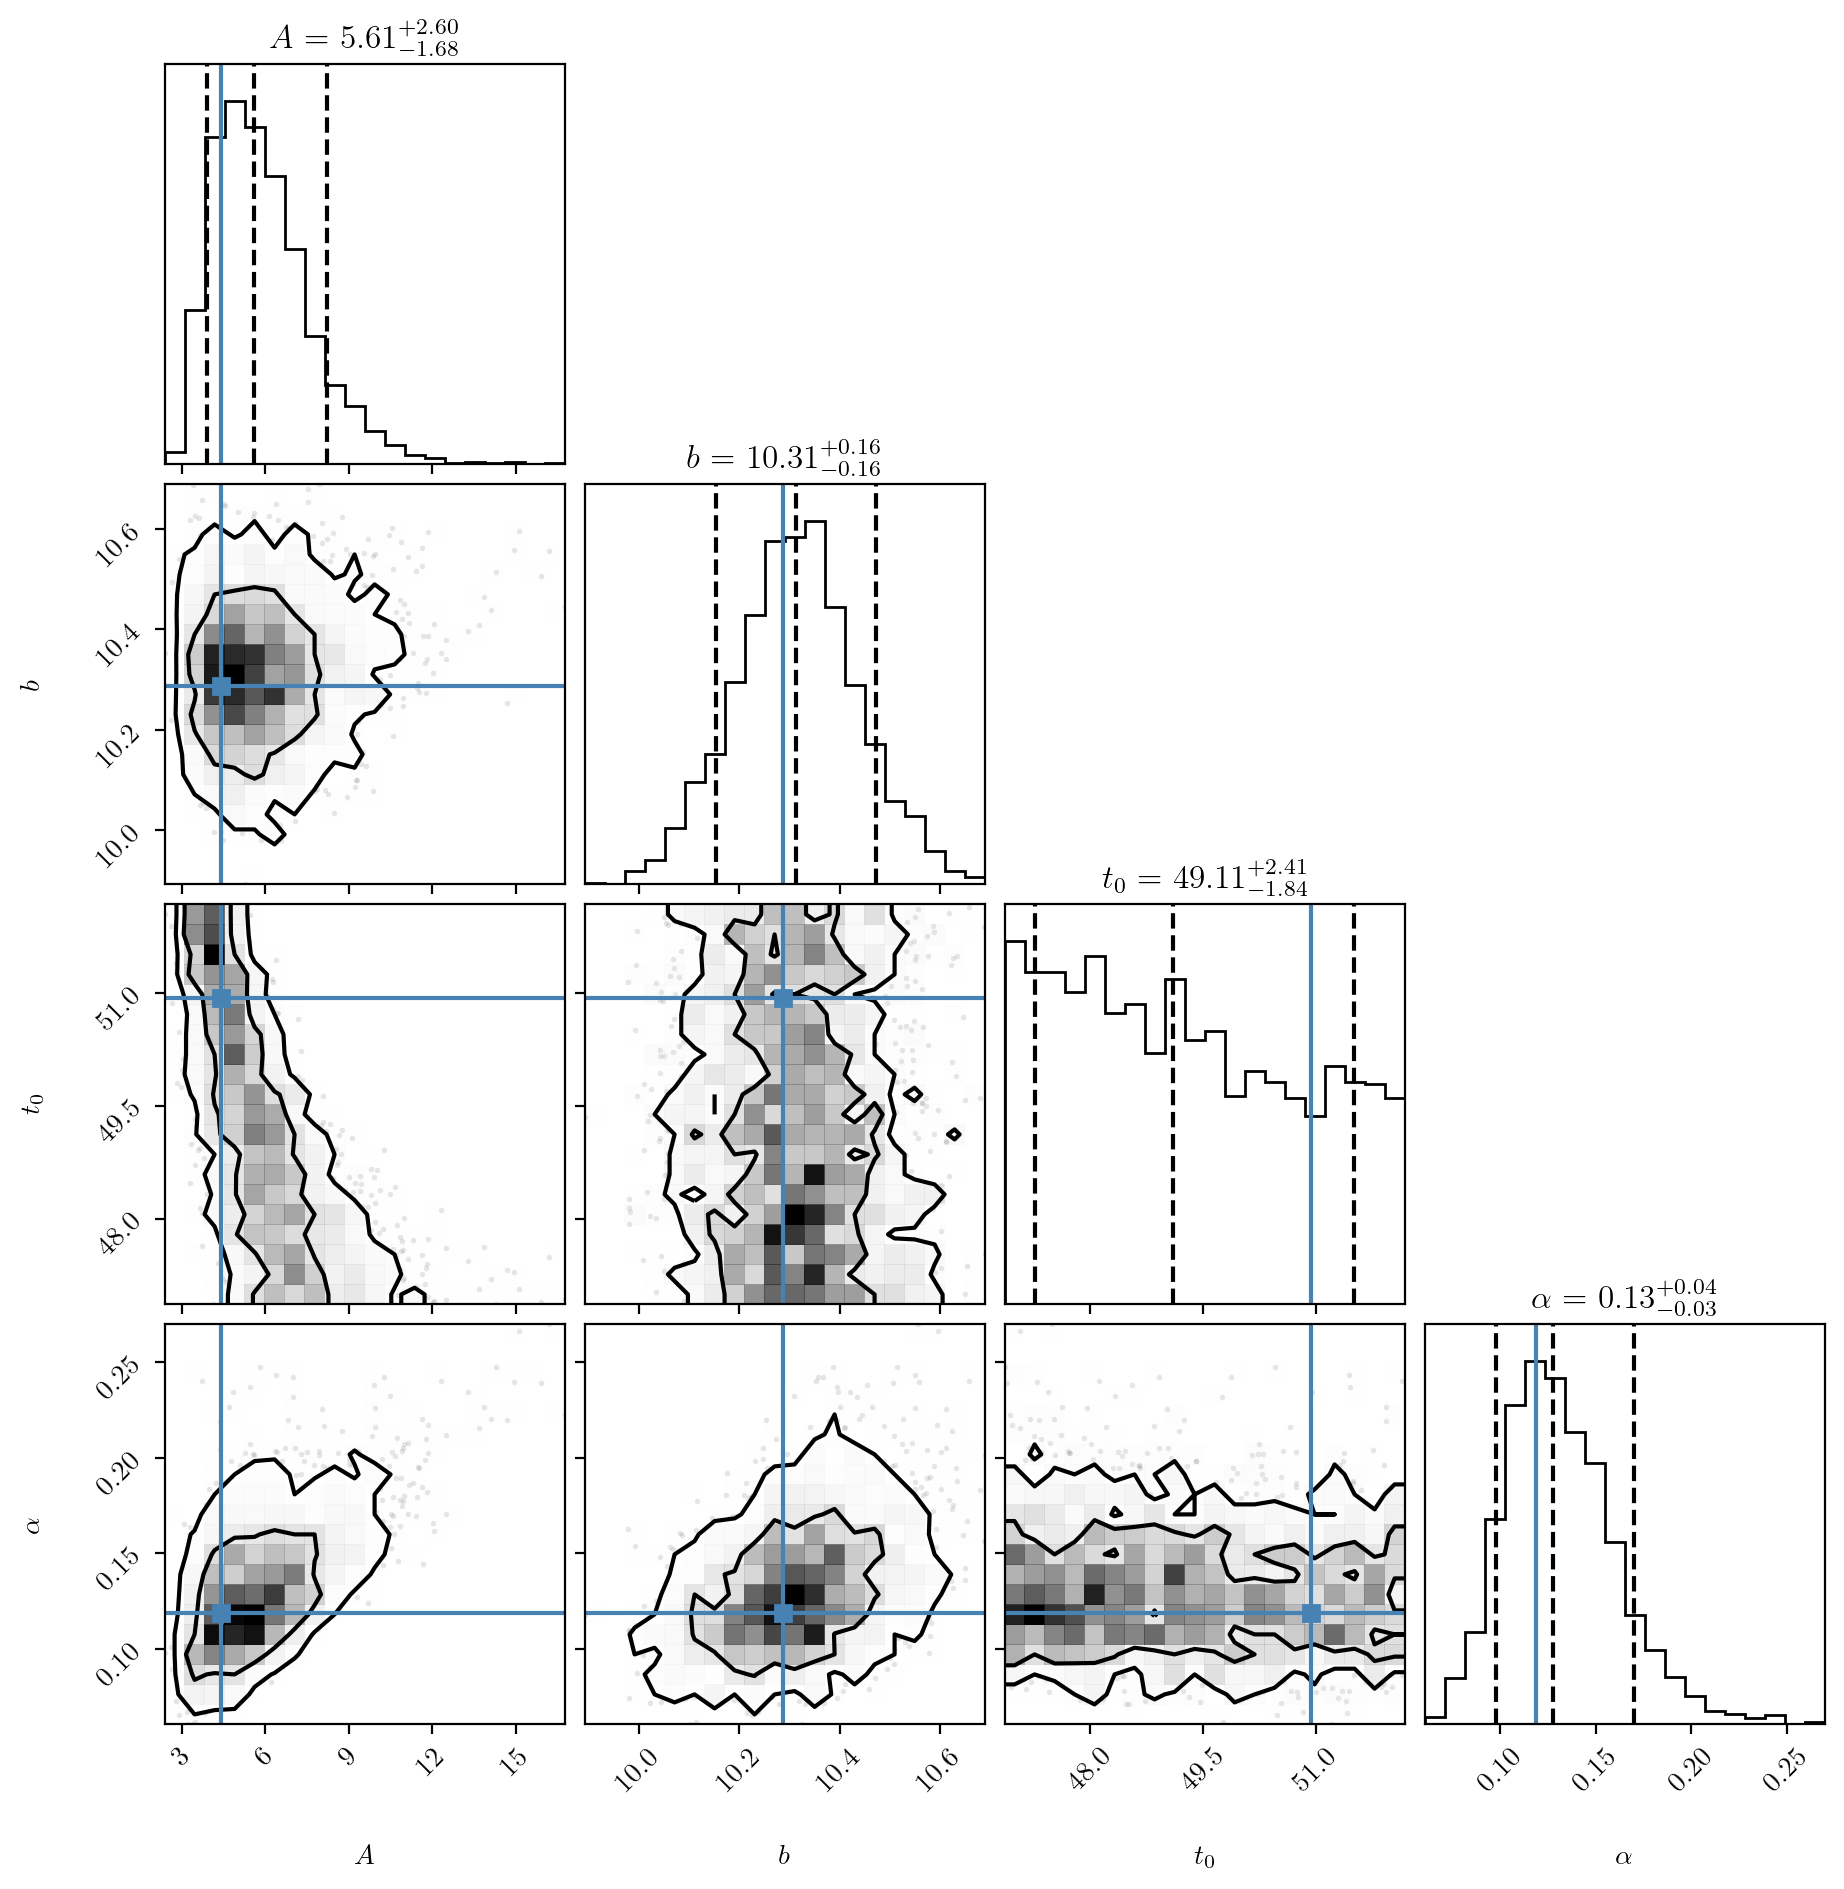

In [15]:
labels = [r'$A$', r'$b$', r'$t_0$', r'$\alpha$']

fig = corner.corner(thin_samples, labels=labels, truths=best_params, levels=[0.68,0.95],
                   quantiles=[0.10, 0.5, 0.90], show_titles=True, title_fmt=".2f",
                   plot_density=True) 
# I plot the MLE parameters as true values

Median and quantiles

In [16]:
for i,l in enumerate(labels):
    low, med, up = np.percentile(thin_samples[:,i],[5,50,95]) 
    print(l+"   "+str(med)+" +"+str(up-med)+" -"+str(med-low))

$A$   5.607893196841557 +3.64667125065513 -1.9649040536883229
$b$   10.312715786413856 +0.20821799899728433 -0.20217080206491467
$t_0$   49.10599577935149 +2.733826682901636 -2.0478663481673536
$\alpha$   0.1276572432874672 +0.057429232699982985 -0.03798672557070511


#### Choose $100$ samples randomly and plot the model

NB: each sample in my posterior is a possible realisation (equally probable)

In [17]:
nsamples = 100
chosen_samples= thin_samples[np.random.choice(len(thin_samples),size=nsamples)]
print(chosen_samples.shape)

(100, 4)


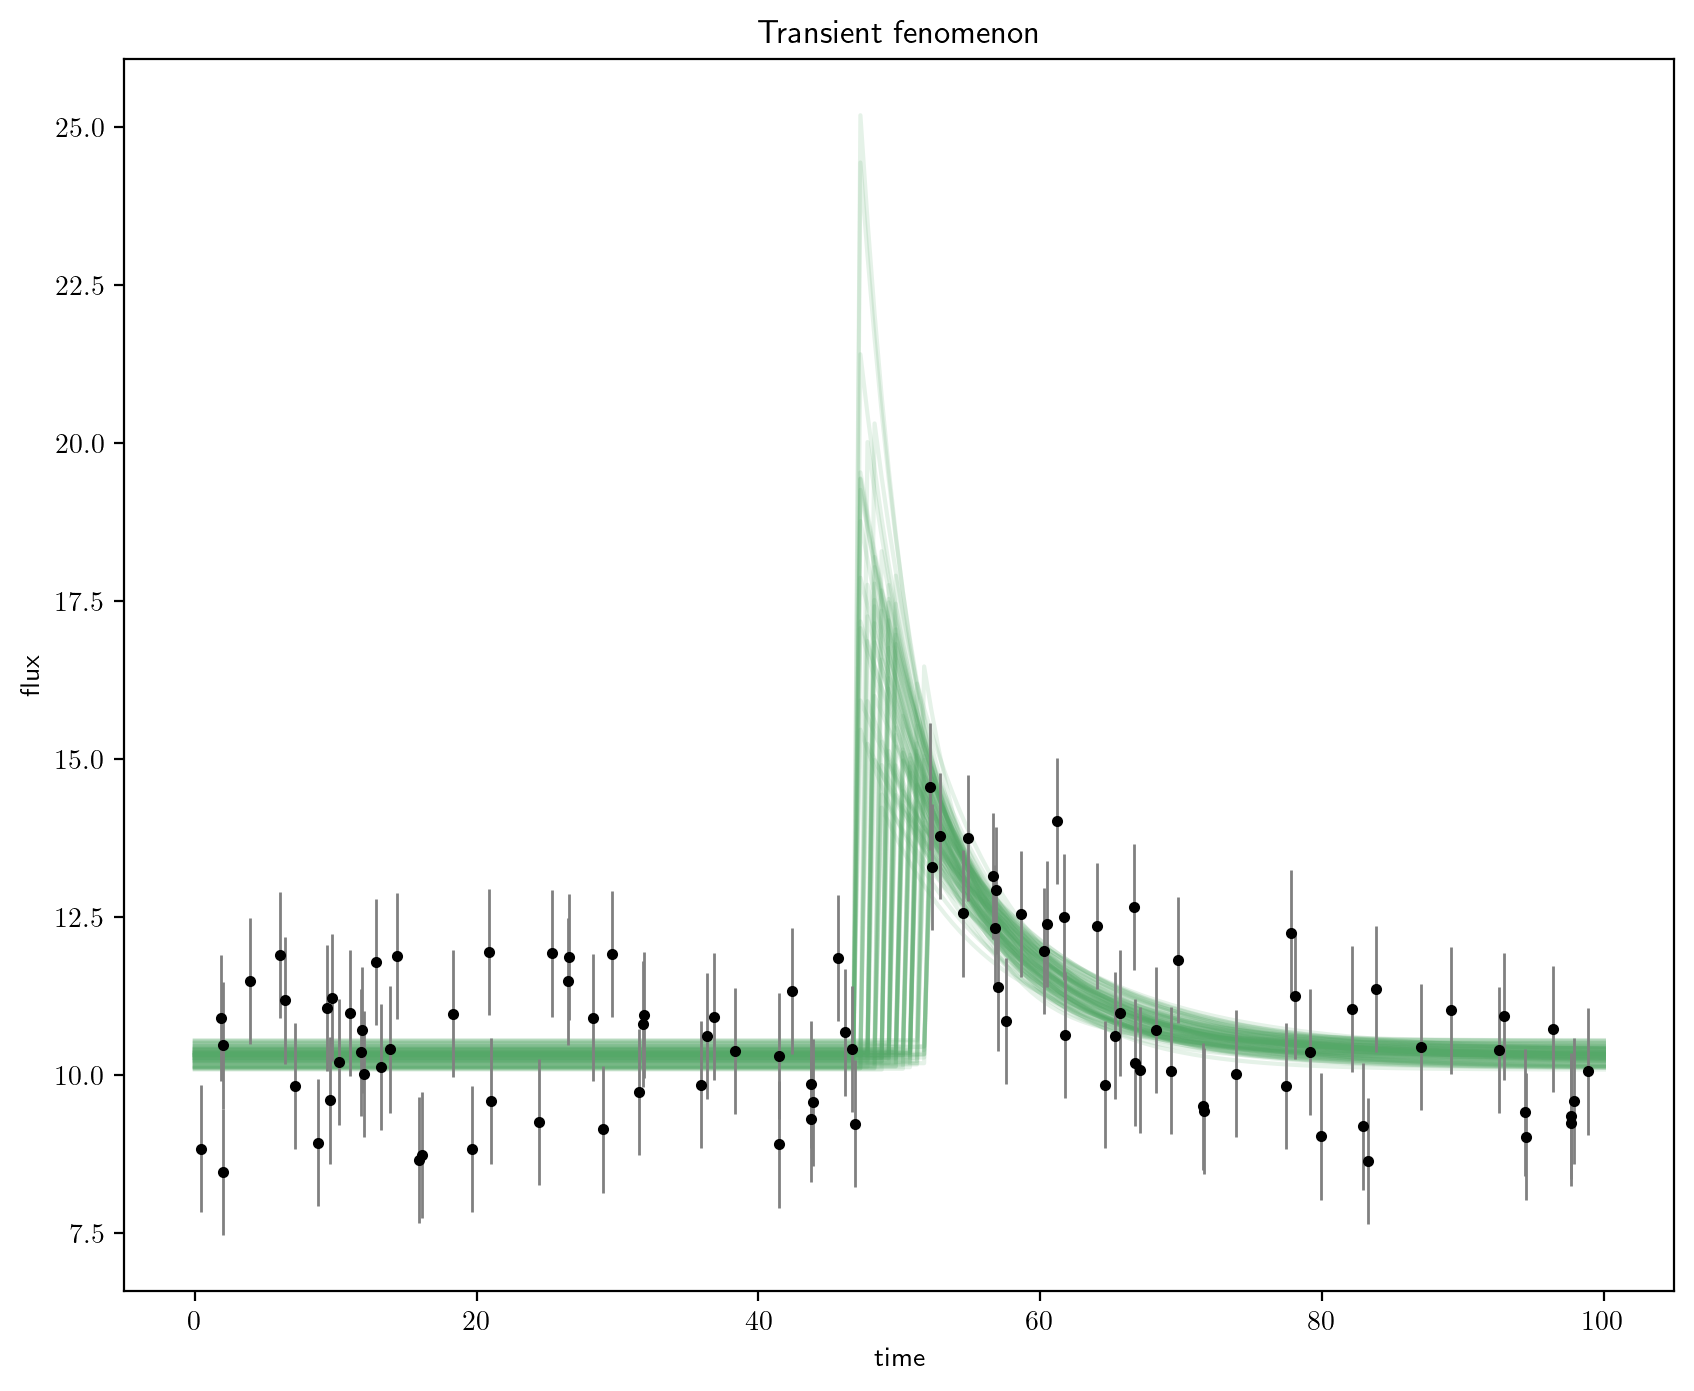

In [18]:
tgrid=np.linspace(0,100,200)

plt.figure(figsize=(10,8))

for i in range(nsamples):
    plt.plot(tgrid, burst_model(tgrid, chosen_samples[i,:]), 'C1', alpha = 0.15)
plt.xlabel("time")
plt.ylabel("flux")

plt.errorbar(t,y,yerr=yerr, fmt='.', color='k', ecolor='gray', elinewidth=1)
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Transient fenomenon')

plt.show()